## The SEI3R Model

Another extension of SIR, designed during the paper we read for this work, https://arxiv.org/pdf/2003.13221.pdf, Planning as Inference in Epedimiological Control Models. 

### Model Dynamics


A member of the susceptible population $S$ moves to the exposed $E$ after being exposed to an infections person, where "exposure" is defined as the previously susceptible person contracting the illness. 

After an incubation period, a random duration parameterized by $\alpha$, the individual develops a mild infection $I_1$, from here, the indivdual either moves to recover $R$, or progress to a severe infection $I_2$. At $I_2$ they again either recover, or progress to critical infection $I_3$. From $I_3$, the critically ill individual will either die or recover. 

The summed population of all compartments at time $t$ is $N_t$. For the purposes of are work, we keep this value fixed. 

The dynamics of this system are defined by the following equations:


$$\frac{d}{dt}S_t = - (1 - u) \frac{1}{N_t} \sum_{i=1}^3 \beta_i I_{i,t}S_t$$

$$\frac{d}{dt}E = (1 - u) \frac{1}{N_t} \sum_{i=1}^3 \beta_i I_{i,t}S_t - \alpha E_t $$

$$\frac{d}{dt} I_{1,t} = \alpha E_t -p_1 I_{1,t} - \gamma_1 I_{1,t}$$


$$\frac{d}{dt} I_{2,t} =  p_1 I_{1,t} -p_2 I_{2,t} - \gamma_2 I_{2,t}$$


$$\frac{d}{dt} I_{3,t} =  p_2 I_{2,t} -p_3 I_{3,t} - \gamma_3 I_{3,t}$$


$$\frac{d}{dt} R_{t} = \gamma_1 I_{1,t} + \gamma_2 I_{2,t} +  \gamma_3 I_{3,t}$$





For simulations with this model, we initialize with $0.01 \%$ of the population as exposed, and the remaining $99.99 \%$ as susceptible. 

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
#assert pyro.__version__.startswith('1.5.0') # I have 1.5.1, hopefully not a problem to comment this out. 
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
pyro.enable_validation(True)  # Always a good idea.
smoke_test = ('CI' in os.environ)

In [15]:

# check https://github.com/SwapneelM/covid/blob/master/SEIR/seir.py for help. 
class SEI3RModel(CompartmentalModel):
    """
    Susceptible-Exposed-Infected1-Infected2-Infected3-Recovered-(Dead) model.

    This is a stochastic discrete-time discrete-state model with seven
    compartments: "S" for susceptible, "E" for exposed, "I" for infected (with 3 degrees of illness), "D"
    for deceased individuals, and "R" for recovered individuals (the recovered
    individuals are implicit: ``R = population - S - E - I1 - I2 - I3 - D``) with
    transitions ``S -> E -> I1 -> R``,  ``S -> E -> I1 -> I2 -> R``,  ``S -> E -> I1 -> -> I2 -> I3 -> R``
    and ``I3 -> D``.

    Because the transitions are not simple linear succession, this model
    implements a custom :meth:`compute_flows()` method.

    :param int population: Total ``population = S + E + I1 + I2 + I3 + R + D``.
    :param float incubation_time: Mean incubation time (duration in state
        ``E``). Must be greater than 1.
    :param float recovery_time: Mean recovery time (duration in state
        ``I``). Must be greater than 1.
    :param float mortality_rate: Portion of infections resulting in death.
        Must be in the open interval ``(0, 1)``.
    :param iterable data: Time series of new observed infections. Each time
        step is Binomial distributed between 0 and the number of ``S -> E``
        transitions. This allows false negative but no false positives.
    """

    def __init__(self, population, incubation_time, recovery_time,
                 mortality_rate, data):
        compartments = ("S", "E", "I", "I2", "I3", "R1","R2","R3")  # D is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)

        assert isinstance(incubation_time, float)
        assert incubation_time > 1
        self.incubation_time = incubation_time

        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        self.recovery_time = recovery_time

        assert isinstance(mortality_rate, float)
        assert 0 < mortality_rate < 1
        self.mortality_rate = mortality_rate

        self.data = data

    def global_model(self):
        tau_e = self.incubation_time
        
        tau_i = self.recovery_time
                
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = pyro.sample("rho", dist.Beta(10, 10))
        
        IncubPeriod = 14
        DurMildInf = 6
        FracMild = 0.81
        FracSevere = 0.14
        FracCritical = 0.05
        CFR = 0.02

        DurHosp = 10.5
        TimeICUDeath = 11.2 # https://arxiv.org/pdf/2002.03268.pdf


        gamma1=(1/DurMildInf)*FracMild
        p1=(1/DurMildInf)-gamma1
        p2=(1/DurHosp)*(FracCritical/(FracSevere+FracCritical))
        gamma2=(1/DurHosp)-p2
        kappa=(1/TimeICUDeath)*(CFR/FracCritical)
        gamma3=(1/TimeICUDeath)-kappa
        
        kappa = (1/TimeICUDeath)*(CFR/FracCritical)

        return R0, rho, tau_e, tau_i, p1,gamma1, p2,gamma2, gamma3, kappa
    

    def initialize(self, params):
        # Start with a single infection ( at stage 1) .
        # pretty ambiguous. Check with paper see if they do something different. 
        return {"S": self.population *.99 , "E": 0, "I": self.population * .01, "I2":0, "I3":0, "R1": 0,  "R2": 0,  "R3": 0}

    
    
    def transition(self, params, state, t):
        """
        How we go from one compartment to another. After definining changes we update compartments. 
        
        """
        R0, rho, tau_e, tau_i, p1,gamma1, p2,gamma2, gamma3, kappa = params # add the other ones from paper
        

        # Sample flows between compartments.
        S2E = pyro.sample("S2E_{}".format(t),
                          infection_dist(individual_rate=R0 / tau_i,
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        
        E2I = pyro.sample("E2I_{}".format(t),
                          binomial_dist(state["E"], 1 / tau_e))
        
        I2I2 = pyro.sample("I2I2_{}".format(t),
                          binomial_dist(state["I"], p1))
        
        I2R1 = pyro.sample("I2R1_{}".format(t),
                          binomial_dist(state["I"], gamma1))
       
        I22I3 = pyro.sample("I22I3_{}".format(t),
                          binomial_dist(state["I2"], p2))
        
        I22R2 = pyro.sample("I22R2_{}".format(t),
                          binomial_dist(state["I2"], gamma2))
        
        
        I32R3 = pyro.sample("I32R3_{}".format(t),
                          binomial_dist(state["I3"], gamma3))
        
        I32D = pyro.sample("I32D_{}".format(t),
                          binomial_dist(state["I3"], kappa))
        
        

        # update compartments. 
        state["S"] = state["S"] - S2E
        state["E"] = state["E"] + S2E - E2I
        state["I"] = state["I"] + E2I - I2R1 - I2I2
        state["R1"] = state["R1"] + I2R1
        state["I2"] = state["I2"] + I2I2 - I22R2 - I22I3
        state["R2"] = state["R2"] + I22R2
        state["I3"] = state["I3"] + I22I3 - I32R3 - I32D
        state["R3"] = state["R3"] + I32R3
        
        
        
        

        # Condition on observations. 
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2E, rho),
                    obs=self.data[t] if t_is_observed else None)

    def compute_flows(self, prev, curr, t):
        """
        Having a tough time making these line up. Need to choose one to define first? 
        
        Should a new variable be implicit? 
        """
        
        # First part, flow through first parts
        S2E = prev["S"] - curr["S"]  # S can only go to E.
        E2I = prev["E"] - curr["E"] + S2E
        
        
        
        I2R1 = curr["R1"] - prev["R1"] #only one place it can come from... 
        
        I2I2 = prev["I"] - curr["I"] + E2I - I2R1
        
        I22R2 = curr["R2"] - prev["R2"] #only one place it can come from... 
        
        
        I22I3 = prev["I2"] - curr["I2"] + I2I2 - I22R2
        
        I32R3 = curr["R3"] - prev["R3"] #only one place it can come from... 

        I32D = prev["I3"] - curr["I3"] + I22I3 - I32R3

        
        
        return {
            "S2E_{}".format(t): S2E,
            "E2I_{}".format(t): E2I,
            "I2I2_{}".format(t): I2I2,
            "I22I3_{}".format(t): I22I3,
            "I32D_{}".format(t): I32D,
            "I2R1_{}".format(t): I2R1,
            "I22R2_{}".format(t): I22R2,
            "I32R3_{}".format(t): I32R3,

        }



In [16]:
from argparse import Namespace
args = Namespace(population=10000, 
                 incubation_time = 7.,
                 min_observations=3000,
                 max_observations=5000,
                 duration=300,
                 forecast=25, 
                 basic_reproduction_number=5.5,  # what our epidemic's R0 is.
                 recovery_time=24.0,  #recovery time. These values are 
                 response_rate=0.85,  # this is the probability of observed infections (noisy)
                 enum=True, 
                 sequential=True, 
                 num_samples=1000, 
                 warmup_steps=100, 
                 max_tree_depth=5, 
                 rng_seed=0, 
                 mortality_rate=.5,
                 double=True, 
                 jit=True, 
                 cuda=False, 
                 verbose=True, 
                 plot=True,
                 policy_intervention=0)



In [17]:
empty_data = [None] * args.duration # fill this array if you wish to condition on real world data. 
model = SEI3RModel(args.population, args.incubation_time,args.recovery_time, args.mortality_rate, empty_data)


# We'll repeatedly generate data until a desired number of infections is found.
for attempt in range(100):
    synth_data = model.generate({"R0": args.basic_reproduction_number,"u":args.policy_intervention}) # starting values for R0 and u. 
    total_infections = synth_data["S2E"].sum().item()
    print('total_infections:',total_infections)
    if args.min_observations <= total_infections <= args.max_observations:
        break
print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))

total_infections: 4691.0
Simulated 4691.0 infections after 1 attempts


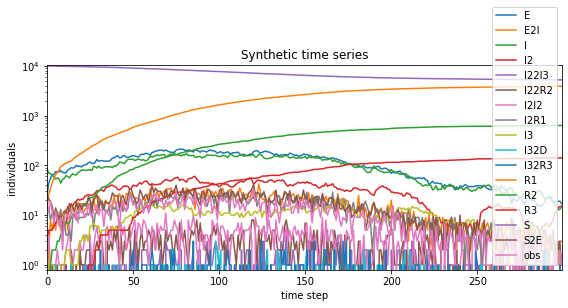

In [18]:
plt.figure(figsize=(8,4))
for name, value in sorted(synth_data.items()):
    if value.dim():
        plt.plot(value, label=name)
plt.xlim(0, len(empty_data) - 1)
plt.ylim(0.8, None)
plt.xlabel("time step")
plt.ylabel("individuals")
plt.yscale("log")
plt.legend(loc="best")
plt.title("Synthetic time series")
plt.tight_layout()

In [19]:
synth_data['R1'] + synth_data["R2"] + synth_data["R3"]

tensor([  13.,   26.,   35.,   47.,   56.,   67.,   75.,   85.,   99.,  103.,
         112.,  117.,  121.,  126.,  131.,  142.,  152.,  161.,  169.,  180.,
         190.,  200.,  211.,  224.,  237.,  251.,  270.,  275.,  289.,  303.,
         317.,  343.,  360.,  374.,  386.,  400.,  418.,  429.,  446.,  464.,
         482.,  498.,  512.,  533.,  546.,  563.,  577.,  594.,  627.,  652.,
         671.,  698.,  717.,  729.,  749.,  773.,  788.,  810.,  832.,  849.,
         868.,  893.,  914.,  938.,  959.,  985., 1009., 1031., 1056., 1094.,
        1119., 1145., 1176., 1201., 1227., 1255., 1271., 1303., 1333., 1357.,
        1391., 1416., 1449., 1481., 1513., 1541., 1568., 1602., 1626., 1656.,
        1683., 1710., 1732., 1750., 1772., 1803., 1832., 1855., 1883., 1915.,
        1940., 1969., 1990., 2020., 2044., 2081., 2096., 2126., 2159., 2188.,
        2207., 2229., 2253., 2278., 2308., 2332., 2350., 2368., 2393., 2423.,
        2453., 2486., 2503., 2527., 2558., 2591., 2627., 2650., 

In [20]:

obs = synth_data["obs"]
model = SEI3RModel(args.population, args.incubation_time,args.recovery_time, args.mortality_rate, obs)


In [21]:
%%time
mcmc = model.fit_mcmc(num_samples=4 if smoke_test else 1000,
                      jit_compile=True,)

INFO 	 Running inference...
Warmup:   0%|          | 0/2000 [00:00, ?it/s]INFO 	 Heuristic init: R0=5.29, rho=0.62
/scratch/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/torch/autograd/__init__.py:202: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return Variable._execution_engine.run_backward(
Sample: 100%|██████████| 2000/2000 [05:21,  6.22it/s, step size=6.75e-03, acc. prob=0.850]


CPU times: user 5min 16s, sys: 404 ms, total: 5min 16s
Wall time: 5min 21s


In [22]:
%%time
samples = model.predict()

INFO 	 Predicting latent variables for 300 time steps...


CPU times: user 1.62 s, sys: 55.7 ms, total: 1.68 s
Wall time: 1.69 s


In [23]:
for key, value in sorted(samples.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

E.shape = (1000, 300)
E2I.shape = (1000, 300)
I.shape = (1000, 300)
I2.shape = (1000, 300)
I22I3.shape = (1000, 300)
I22R2.shape = (1000, 300)
I2I2.shape = (1000, 300)
I2R1.shape = (1000, 300)
I3.shape = (1000, 300)
I32D.shape = (1000, 300)
I32R3.shape = (1000, 300)
R0.shape = (1000, 1)
R1.shape = (1000, 300)
R2.shape = (1000, 300)
R3.shape = (1000, 300)
S.shape = (1000, 300)
S2E.shape = (1000, 300)
auxiliary.shape = (1000, 1, 8, 300)
obs.shape = (1000, 300)
rho.shape = (1000, 1)


/scratch/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratch/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


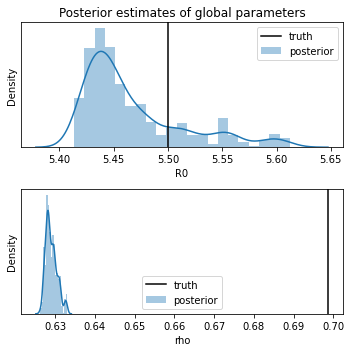

In [24]:
names = ["R0", "rho"]
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    truth = synth_data[name]
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(truth, color="k", label="truth")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
plt.tight_layout()

In [25]:
%time
samples = model.predict(forecast=30)

INFO 	 Predicting latent variables for 300 time steps...


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


INFO 	 Forecasting 30 steps ahead...


In [27]:
args.population

10000

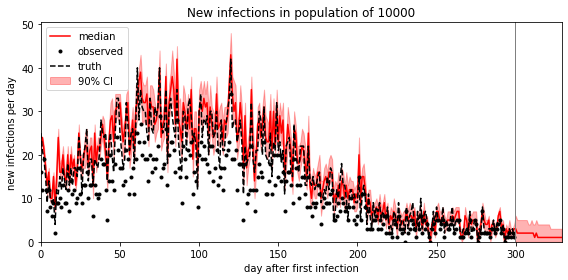

In [28]:

def plot_forecast(samples):
    duration = len(empty_data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])

    time = torch.arange(duration + forecast)
    S2E = samples["S2E"]
    median = S2E.median(dim=0).values
    p05 = S2E.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2E.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    plt.figure(figsize=(8, 4))
    plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    plt.plot(time, median, "r-", label="median")
    plt.plot(time[:duration], obs, "k.", label="observed")
    plt.plot(time[:duration], synth_data["S2E"], "k--", label="truth")
    plt.axvline(duration - 0.5, color="gray", lw=1)
    plt.xlim(0, len(time) - 1)
    plt.ylim(0, None)
    plt.xlabel("day after first infection")
    plt.ylabel("new infections per day")
    plt.title("New infections in population of {}".format(args.population))
    plt.legend(loc="upper left")
    plt.tight_layout()

plot_forecast(samples)